In [130]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pingouin as pg
import seaborn as sns
import pandas as pd
from scipy import stats
from statannotations.Annotator import Annotator

%matplotlib widget
sns.set_palette("pastel")
palette = sns.color_palette("pastel")

<h1 style="text-align:center">Dataset Loading</h1>

In [2]:
data = pd.read_excel("data/Telomere MDD.xlsx")

In [3]:
data.info(verbose=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   telomere_length                64 non-null     float64
 1   age                            64 non-null     int64  
 2   sex                            64 non-null     int64  
 3   civil_status                   64 non-null     int64  
 4   educ_level                     64 non-null     int64  
 5   employ_stat                    64 non-null     int64  
 6   ses                            64 non-null     int64  
 7   average_sleep                  64 non-null     int64  
 8   smoking_daily_ave              64 non-null     int64  
 9   alcohol_daily_ave              64 non-null     int64  
 10  prohibited_drug                64 non-null     int64  
 11  prohibited_drug_type           64 non-null     int64  
 12  fruit_veg                      64 non-null     int64

<h1 style="text-align:center">Participant Distribution</h1>

In [4]:
sex_labels = data.sex.map({1:"Male", 2:"Female"})

<h2>Age Distribution by Sex</h2>

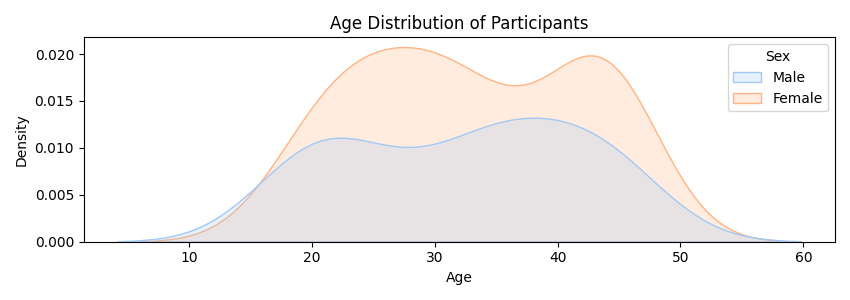

In [ ]:
age_distribution_fig, age_distribution_axis = plt.subplots(1,1, figsize=(8.5,3))

sns.kdeplot(data=data, x="age", hue=sex_labels, ax=age_distribution_axis,
            common_norm=True,
            palette="pastel",
            fill=True)

age_distribution_axis.set(title="Age Distribution of Participants",
                          xlabel="Age",
                          ylabel="Density")

age_distribution_axis.get_legend().set_title("Sex")

age_distribution_fig.tight_layout()
age_distribution_fig.savefig("figures/Age Distribution.png", dpi=300)

<h2>Telomere Variation by Age</h2>

In [6]:
a_tl_linreg = stats.linregress(x=data.age, y=data.telomere_length)

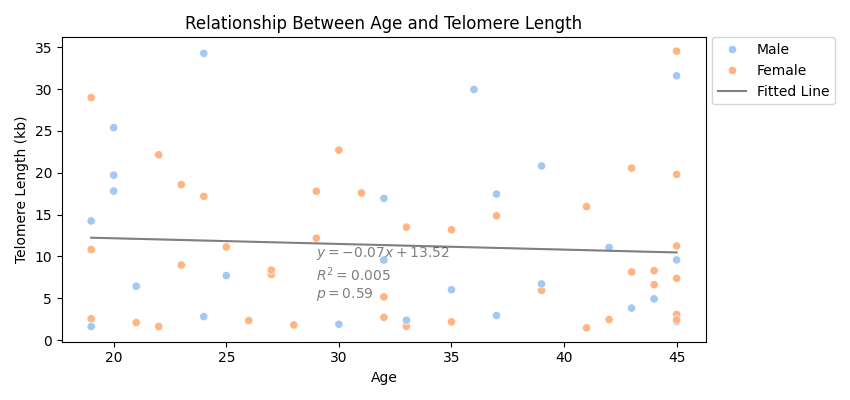

In [71]:
age_vs_tl_fig, age_vs_tl_axis = plt.subplots(1,1, figsize=(8.5,4))
age_vs_tl_axis.set(title="Relationship Between Age and Telomere Length",
                   xlabel="Age", ylabel="Telomere Length (kb)")

sns.scatterplot(x=data.age, y=data.telomere_length, hue=sex_labels, ax=age_vs_tl_axis)

sns.lineplot(x=data.age, y=(a_tl_linreg.slope*data.age+a_tl_linreg.intercept), label="Fitted Line", ax=age_vs_tl_axis,
             color="gray")

age_vs_tl_axis.text(x=29, y=5,
                    s=f"$y={a_tl_linreg.slope:.2f}x+{a_tl_linreg.intercept:.2f}$"
                    f"\n$R^{2} = {a_tl_linreg.rvalue**2:.3f}$"
                    f"\n$p = {a_tl_linreg.pvalue:.2f}$",
                    alpha=0.5)


age_vs_tl_axis.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

age_vs_tl_fig.tight_layout()
age_vs_tl_fig.savefig("figures/Age vs. Telomere Length (Linear Regression).png", dpi=300)

<h1 style="text-align:center">Telomere Length Variation By Sex</h1>

<h2>Test for Normality (Shapiro-Wilk Test)</h2>

In [8]:
sex_tl_temp = data[["sex", "telomere_length"]].copy()
sex_tl_temp["sex"] = sex_labels
pg.normality(data=sex_tl_temp, dv="telomere_length", group="sex", method="shapiro")

,W,pval,normal
sex,,,
Male,0.884849,0.008714,False
Female,0.906191,0.003336,False


<h2>Test for Homoscedasticity (Levene's Test)</h2>

In [9]:
pg.homoscedasticity(data=sex_tl_temp, dv="telomere_length", group="sex", method="levene")

,W,pval,equal_var
levene,0.877211,0.352601,True


<h2>Group Comparison (Mann-Whitney Test) & Visualization</h2>

In [10]:
sex_tl_comp = stats.mannwhitneyu(x=data.loc[data.sex == 1, "telomere_length"],
                                        y=data.loc[data.sex == 2, "telomere_length"])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Male vs. Female: Mann-Whitney-Wilcoxon test two-sided, P_val:6.203e-01 U_stat=5.240e+02


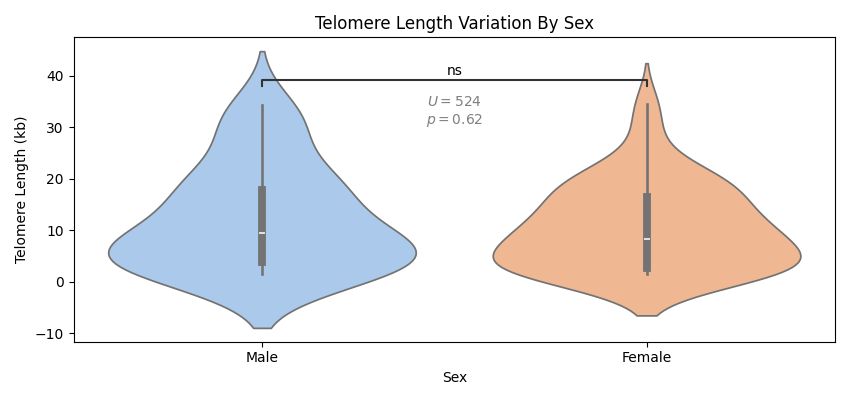

In [79]:
sex_tl_fig, sex_tl_axis = plt.subplots(1,1, figsize=(8.5,4))
sex_tl_axis.set(title="Telomere Length Variation By Sex",
                   xlabel="Sex", ylabel="Telomere Length (kb)")

sns.violinplot(x=sex_labels, y=data.telomere_length, hue=sex_labels,
               fill=True)


annotator = Annotator(ax=sex_tl_axis, pairs=[("Male", "Female")], x=sex_labels, y=data.telomere_length)
annotator.configure(test='Mann-Whitney', text_format="star", loc="inside")
annotator.apply_and_annotate()

sex_tl_axis.text(0.5,33,
                 f"$U = {sex_tl_comp.statistic:.0f}$"
                 f"\n$p = {sex_tl_comp.pvalue:.2f}$",
                 alpha=0.5,
                 ha="center",
                 va="center")

sex_tl_fig.tight_layout()
sex_tl_fig.savefig("figures/Telomere Length Variation By Sex (Mann-Whitney).png", dpi=300)

<h1 style="text-align:center">Treatment Reponse Analysis</h1>

In [178]:
mode_names = ["Counselling", "Medication", "Hybrid"]

hamd_response_labels = data.hamd_response.map({1:"Responders", 2:"Non-Responders"})
hamd_responders = data.loc[data.hamd_response == 1, "treatment_mode"]
hamd_councelling_response, hamd_medication_response, hamd_hybrid_response = [data.loc[data["treatment_mode"] == mode, ["hamd_response"]] for mode in [1,2,3]]
hamd_mode_response = [hamd_councelling_response, hamd_medication_response, hamd_hybrid_response]

phq9_response_labels = data.phq9_response.map({1:"Responders", 2:"Non-Responders"})
phq9_responders = data.loc[data.phq9_response == 1, "treatment_mode"]
phq9_councelling_response, phq9_medication_response, phq9_hybrid_response = [data.loc[data["treatment_mode"] == mode, ["phq9_response"]] for mode in [1,2,3]]
phq9_mode_response = [phq9_councelling_response, phq9_medication_response, phq9_hybrid_response]

color_palette = sns.color_palette("pastel")

<h2>HAMD</h2>

<h3>Telomere Length Variation in Responders and Non-Responders</h3>

<h4>Test for Normality (Shapiro Wilk Test)</h4>

In [182]:
hamd_response_tl_temp = data[["hamd_response", "telomere_length"]].copy()
hamd_response_tl_temp["hamd_response"] = hamd_response_labels

pg.normality(data=hamd_response_tl_temp, dv="telomere_length", group="hamd_response", method="shapiro")

,W,pval,normal
hamd_response,,,
Responders,0.914493,0.038438,False
Non-Responders,0.873280,0.000412,False


<h4>Test for Homoscedasticity (Levene's Test)</h4>

In [183]:
pg.homoscedasticity(data=hamd_response_tl_temp, dv="telomere_length", group="hamd_response", method="levene")

,W,pval,equal_var
levene,0.211437,0.647252,True


<h4>Group Comparison (Mann-Whitney Test) & Visualization</h4>

In [ ]:
hamd_response_tl_comp = stats.mannwhitneyu(x=data.loc[data.hamd_response == 1, "telomere_length"],
                                        y=data.loc[data.hamd_response == 2, "telomere_length"])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Responders vs. Non-Responders: Mann-Whitney-Wilcoxon test two-sided, P_val:6.899e-01 U_stat=5.170e+02


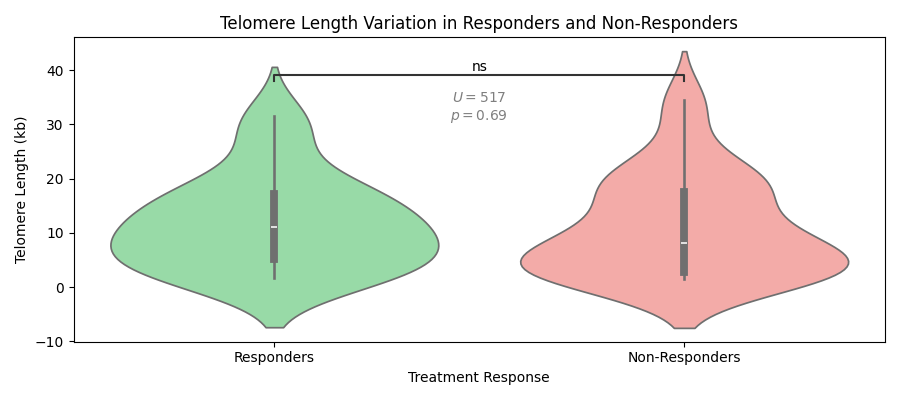

In [193]:
hamd_response_tl_fig, hamd_response_tl_ax = plt.subplots(1,1, figsize=(9, 4))

hamd_response_tl_ax.set(title="Telomere Length Variation in Responders and Non-Responders",
                        xlabel="Treatment Response",
                        ylabel="Telomere Length (kb)")

sns.violinplot(x=hamd_response_labels,
               y=data.telomere_length, ax=hamd_response_tl_ax,
               hue=hamd_response_labels,
               palette={"Responders":palette[2], "Non-Responders":palette[3]})

annotator = Annotator(ax=hamd_response_tl_ax, pairs=[("Responders", "Non-Responders")], x=hamd_response_labels, y=data.telomere_length)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

hamd_response_tl_ax.text(0.5,33,
                 f"$U = {hamd_response_tl_comp.statistic:.0f}$"
                 f"\n$p = {hamd_response_tl_comp.pvalue:.2f}$",
                 alpha=0.5,
                 ha="center",
                 va="center")

hamd_response_tl_fig.tight_layout()
hamd_response_tl_fig.savefig("figures/(HAMD) Telomere Length Variation in Responders and Non-Responders.png", dpi=300)

In [191]:
plt.close("all")

<h3>Responder Proportion of Each Treatment Mode</h3>

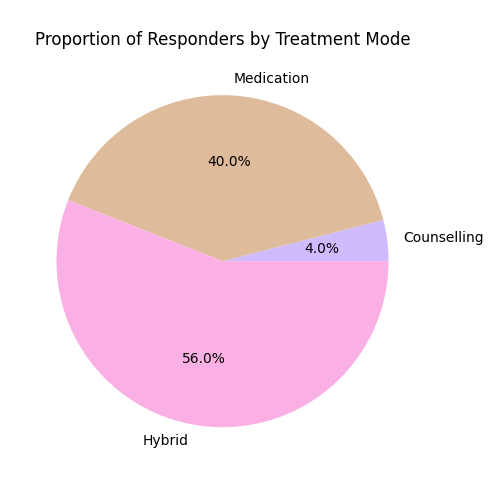

In [132]:
hamd_responders_fig, hamd_responders_ax = plt.subplots(1,1, figsize=(5,5))

plt.pie(x=hamd_responders.value_counts().sort_index(),
        colors=palette[4:],
        autopct="%1.1f%%",
        labels=mode_names)

hamd_responders_ax.set(title="Proportion of Responders by Treatment Mode")

hamd_responders_fig.tight_layout()
hamd_responders_fig.savefig("figures/(HAMD) Proportion of Responders by Treatment Mode.png", dpi=300)

<h3>Response Rate of Each Treatment Mode</h3>

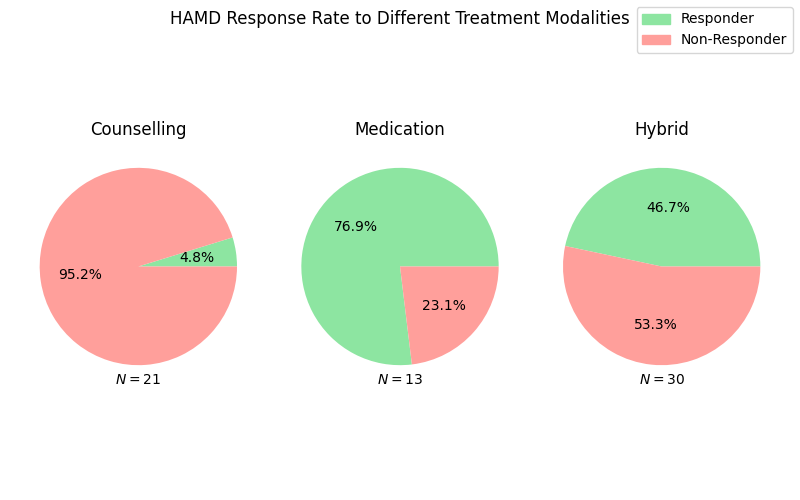

In [194]:
hamd_response_mode_fig, hamd_response_mode_ax = plt.subplots(1,3, figsize=(8,5))
hamd_response_mode_ax.flatten()

hamd_response_mode_fig.suptitle("HAMD Response Rate to Different Treatment Modalities")

for axis, response_data, mode in zip(hamd_response_mode_ax, hamd_mode_response, mode_names):
    response_sum = len(response_data)
    response_rate = response_data.value_counts().sort_index()

    hrm_wedges, hrm_texts, hrm_autotexts = axis.pie(response_rate,  autopct='%1.1f%%', colors=palette[2:])

    axis.text(0,-1.15, s=f"$N = {response_sum}$",
              ha="center",
              va="center")

    axis.set(title=mode)

colors = [w.get_facecolor() for w in hrm_wedges]
labels = ["Responder", "Non-Responder"]
handles = [Patch(color=c, label=str(l)) for c, l in zip(colors, labels)]

hamd_response_mode_fig.legend(handles=handles)

hamd_response_mode_fig.tight_layout()
hamd_response_mode_fig.savefig("figures/HAMD Response Rate By Treatment Mode", dpi=300)

<h2>PHQ-9</h2>

<h3>Telomere Length Variation in Responders and Non-Responders</h3>

<h4>Test for Normality (Shapiro Wilk Test)</h4>

In [203]:
phq9_response_temp = data[["phq9_response", "telomere_length"]].copy()
phq9_response_temp["phq9_response"] = phq9_response_labels
pg.normality(data=phq9_response_temp, dv="telomere_length", group="phq9_response")

,W,pval,normal
phq9_response,,,
Responders,0.908957,0.002699,False
Non-Responders,0.862519,0.005698,False


<h4>Test for Homoscedasticity (Levene's Test)</h4>

In [206]:
pg.homoscedasticity(data=phq9_response_temp, dv="telomere_length", group="phq9_response", method="levene")

,W,pval,equal_var
levene,0.452247,0.503768,True


<h4>Group Comparison (Mann-Whitney Test) & Visualization</h4>

In [210]:
phq9_response_tl_comp = stats.mannwhitneyu(x=data.loc[data.phq9_response==1, "telomere_length"],
                   y=data.loc[data.phq9_response==2, "telomere_length"])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Responders vs. Non-Responders: Mann-Whitney-Wilcoxon test two-sided, P_val:2.733e-01 U_stat=5.400e+02


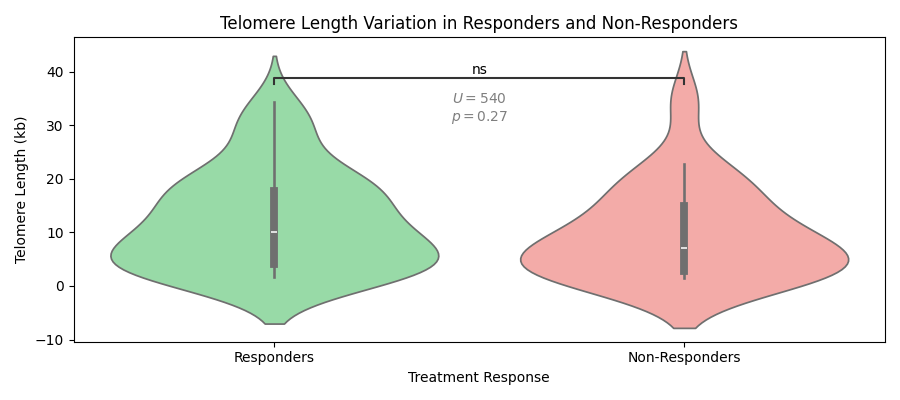

In [213]:
phq9_response_tl_fig, phq9_response_tl_ax = plt.subplots(1,1, figsize=(9, 4))

phq9_response_tl_ax.set(title="Telomere Length Variation in Responders and Non-Responders",
                        xlabel="Treatment Response",
                        ylabel="Telomere Length (kb)")

sns.violinplot(x=phq9_response_labels,
               y=data.telomere_length, ax=phq9_response_tl_ax,
               hue=phq9_response_labels,
               palette={"Responders":palette[2], "Non-Responders":palette[3]})

annotator = Annotator(ax=phq9_response_tl_ax, pairs=[("Responders", "Non-Responders")], x=phq9_response_labels, y=data.telomere_length)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

phq9_response_tl_ax.text(0.5,33,
                 f"$U = {phq9_response_tl_comp.statistic:.0f}$"
                 f"\n$p = {phq9_response_tl_comp.pvalue:.2f}$",
                 alpha=0.5,
                 ha="center",
                 va="center")

phq9_response_tl_fig.tight_layout()
phq9_response_tl_fig.savefig("figures/(PHQ9) Telomere Length Variation in Responders and Non-Responders.png", dpi=300)

<h3>Response Rate of Each Treatment Mode</h3>

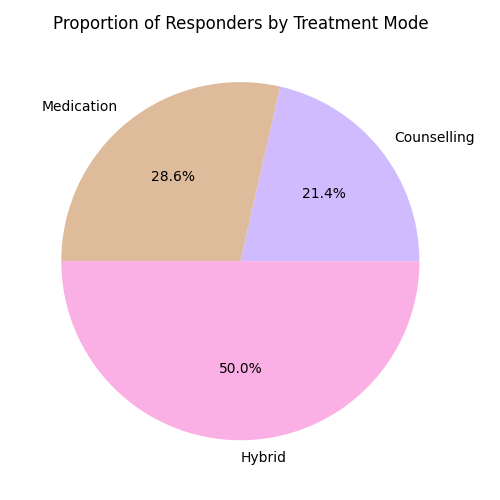

In [87]:
phq9_responders_fig, phq9_responders_ax = plt.subplots(1,1, figsize=(5,5))

plt.pie(x=phq9_responders.value_counts().sort_index(),
        colors=color_palette[4:],
        autopct="%1.1f%%",
        labels=mode_names)

phq9_responders_ax.set(title="Proportion of Responders by Treatment Mode")

phq9_responders_fig.tight_layout()
phq9_responders_fig.savefig("figures/(PHQ9) Proportion of Responders by Treatment Mode.png", dpi=300)

<h3>Response Rate of Each Treatment Mode</h3>

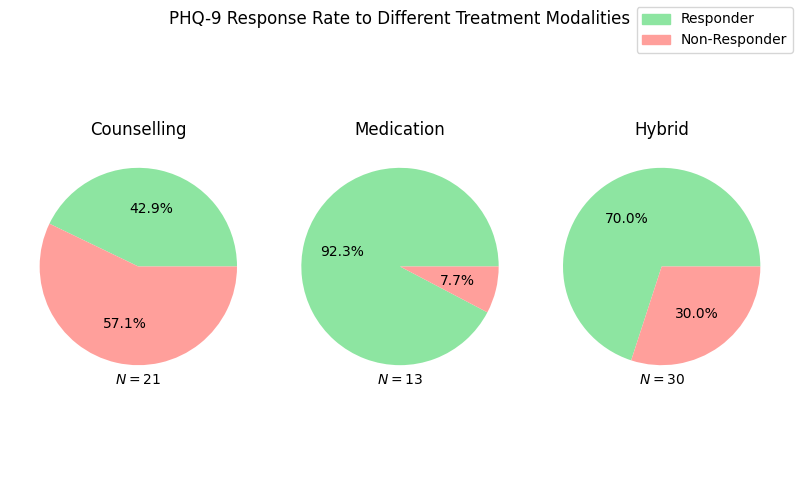

In [136]:
phq9_response_fig, phq9_response_ax = plt.subplots(1,3, figsize=(8,5))
phq9_response_ax.flatten()

phq9_response_fig.suptitle("PHQ-9 Response Rate to Different Treatment Modalities")

for axis, response_data, mode in zip(phq9_response_ax, phq9_mode_response, mode_names):
    response_sum = len(response_data)
    response_rate = response_data.value_counts().sort_index()

    wedges, texts, autotexts = axis.pie(response_rate,  autopct='%1.1f%%', colors= palette[2:])

    axis.text(0,-1.15, s=f"$N = {response_sum}$",
              ha="center",
              va="center")

    axis.set(title=mode)

colors = [w.get_facecolor() for w in wedges]
labels = ["Responder", "Non-Responder"]
handles = [Patch(color=c, label=str(l)) for c, l in zip(colors, labels)]

phq9_response_fig.legend(handles=handles)

phq9_response_fig.tight_layout()
phq9_response_fig.savefig("figures/PHQ9 Response Rate By Treatment Mode.png", dpi=300)

In [66]:
plt.close("all")